# MNIST
First we need to get the dataset. Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset.

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape
#y.shape

(70000, 784)

There are 70,000 images, and each image has 784 features. This is because each image
is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0
(white) to 255 (black). Let us plot one of the images to see how it is like.

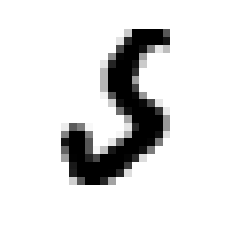

'5'

In [76]:
# import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[69982]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()
y[69982]


We can see that this is the picture of a digit 9, and the label also tells us so. Next we need to split the data set in to training and test set, actully this is already done. The **MNIST** dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images).

In [42]:
import numpy as np
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

After spliting the data we have also suffled the data so that the digits are evenly distributed and we have no problem while performing cross validation.

## Training a Binary Classifier


In [77]:
from sklearn.linear_model import SGDClassifier

y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')
#y_train_5= y_train_5.astype(int) 

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([False])

In [6]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96195, 0.9541 , 0.97055])

## Custom cross-validation

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/home/zenith/environments/anaconda3/envs/tf-testbed/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.96195
0.9541
0.97055


## Performance Measures

In [8]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96195, 0.9541 , 0.97055])

The accuracy of classifier seems to be around $95\%$. But here is the catch, only about $10\%$ of the images are actually 5s. So even if the classifier just guessed `False` all the time it would have an accuracy of $90\%$. This is why accuracy is not a measure of the performance of a Classifier, specially on skewed datasets where one of the labels is much more frequent than others.

## Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confu‐
sion matrix. The general idea is to count the number of times instances of class A are
classified as class B. For example, to know the number of times the classifier confused
images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion
matrix. To compute a confusion matrix we need have a prediction for each of the values we want to test. So we use the function `cross_val_predict`, which performs cross-validation across k folds of the training set and outputs the predictions for each fold. So we have a predction for each instance

In [10]:
#kfold cross-validation
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)


array([[53584,   995],
       [ 1273,  4148]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (the negative class): 53,272 of them were correctly classified as non-5s (they are called true negatives), while the remaining 1,307 were wrongly classified as 5s (false positives). The second row considers the images of 5s (the positive class): 1,077 were wrongly classified as non-5s (false negatives), while the remaining 4,344 were correctly classified as 5s (true positives). A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal.

###### Precision and recall
*Precision*= $\frac{TP}{TP+FP}$

*Recall*= $\frac{TP}{TP+FN}$

Now we cant use precission alone because one easy way to game the precision metric is to make one prediction and make sure its correct. Thats $100\%$ precise, but not a very good prediction. So another metric that goes along with it is *recall* that is the fraction of the total amount of relevant instances that were actually retrieved. And precision measure the fraction of relevant cases retrieved out of the total retrieved cases.

In [31]:
from sklearn.metrics import precision_score, recall_score
print(f"precision_score is {precision_score(y_train_5, y_train_pred)} and \
      recall score is{recall_score(y_train_5, y_train_pred)}.")

precision_score is 0.8065331518568929 and       recall score is0.7651724774026932.


In [40]:
print(f"According to the confusion matrix precision_score sould be {4148/(995+4148)} and  \n recall score should be {4148/(1273+4148)}.")
 #presision
# recall

According to the confusion matrix precision_score sould be 0.8065331518568929 and  
 recall score should be 0.7651724774026932.


So the 5 detector is correct about $81\%$ of the time and it detects about $77\%$ of all the 5s.

## Precision/Recall Tradeoff
